In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2024-05-17 16:43:10.450350: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model loaded successfully.
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Overall Prediction: 0.9117301106452942
Number of red circles detected: 96


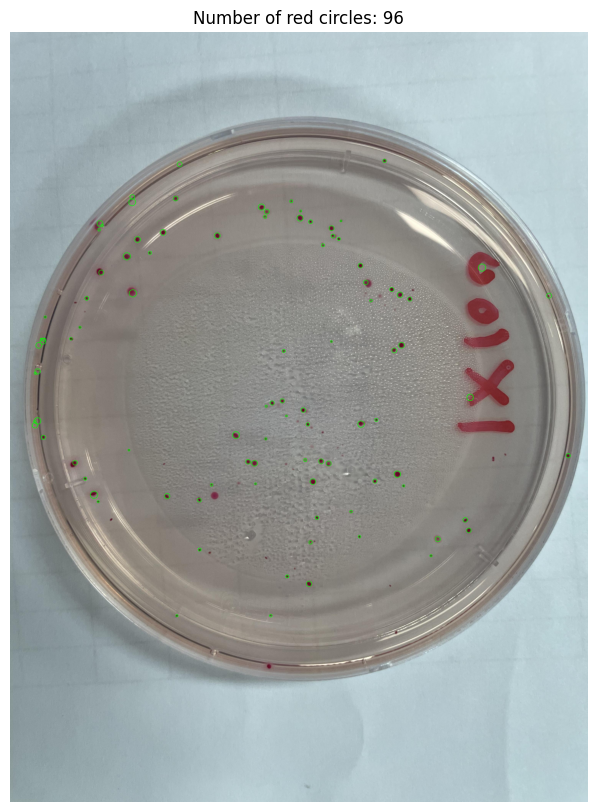

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 학습된 모델 로드
model = load_model('/Users/time/Documents/GitHub/Python/colony_detector_model.h5')
print("Model loaded successfully.")

# 이미지 전처리 및 분할 함수
def preprocess_and_split_image(image_path, tile_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded. Please check the file path.")
    
    h, w, _ = image.shape
    tiles = []
    
    # 이미지를 tile_size 크기로 분할
    for y in range(0, h, tile_size[1]):
        for x in range(0, w, tile_size[0]):
            tile = image[y:y+tile_size[1], x:x+tile_size[0]]
            if tile.shape[0] != tile_size[1] or tile.shape[1] != tile_size[0]:
                # 패딩을 추가하여 크기를 맞춤
                tile = cv2.copyMakeBorder(tile, 0, tile_size[1] - tile.shape[0], 0, tile_size[0] - tile.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))
            tile_scaled = tile / 255.0
            tiles.append(tile_scaled)
    
    tiles = np.array(tiles)
    grid_shape = (len(range(0, h, tile_size[1])), len(range(0, w, tile_size[0])))
    return tiles, grid_shape, h, w  # h와 w를 반환하여 원본 크기를 유지

# 예측 수행 함수
def predict_colony(image_path, model):
    tiles, grid_shape, h, w = preprocess_and_split_image(image_path)
    predictions = model.predict(tiles)
    return predictions, grid_shape, h, w

# 붉은색 동그라미 콜로니를 카운트하는 함수
def count_red_circles(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded. Please check the file path.")

    original_image = image.copy()  # 원본 이미지를 복사하여 저장

    # 이미지를 HSV 색 공간으로 변환
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 붉은색의 범위를 정의 (연한 붉은색 ~ 진한 붉은색)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    # 붉은색에 해당하는 마스크 생성
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 | mask2

    # 마스크에 블러 적용
    blurred = cv2.GaussianBlur(mask, (5, 5), 2)

    # 동그라미 검출
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.4, minDist=10,
                               param1=60, param2=22, minRadius=2, maxRadius=50)

    # 동그라미 카운트 및 이미지에 표시
    circle_count = 0
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            if 4 < r < 20:  # 필터링 조건 추가
                cv2.circle(original_image, (x, y), r, (0, 255, 0), 2)  # 원본 이미지에 동그라미 표시
                circle_count += 1

    return circle_count, original_image  # 원본 크기의 이미지를 반환

# 이미지 경로
image_path = '/Users/time/Documents/GitHub/Python/output.jpg'  # 업데이트된 이미지 경로 사용

# 모델을 사용하여 예측 수행
predictions, grid_shape, h, w = predict_colony(image_path, model)

# 예측 결과를 2D 배열로 재구성
predictions_2d = predictions.reshape(grid_shape)

# 전체 이미지에서 예측된 부분을 결합하여 하나의 결과로 통합
overall_prediction = np.mean(predictions_2d)

print(f"Overall Prediction: {overall_prediction}")

# 예측 결과에 따라 붉은색 동그라미 콜로니 카운트 수행
if overall_prediction > 0.6:  # 임계값을 0.6로 설정하여 콜로니가 있는지 확인
    circle_count, output_image = count_red_circles(image_path)
    print(f"Number of red circles detected: {circle_count}")

    # 결과 이미지 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Number of red circles: {circle_count}")
    plt.axis('off')
    plt.show()
else:
    print("No colonies detected in the image.")


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 학습된 모델 로드
model = load_model('colony_detector_model.h5')
print("Model loaded successfully.")

# 전역 변수 설정
circles = []
dragging = False
selected_circle = None

def draw_circle(event, x, y, flags, param):
    global circles, img_copy, dragging, selected_circle

    if event == cv2.EVENT_LBUTTONDOWN:
        circles = [(x, y)]
        dragging = True
    elif event == cv2.EVENT_MOUSEMOVE and dragging:
        img_copy = img.copy()
        cv2.circle(img_copy, circles[0], int(np.sqrt((x - circles[0][0])**2 + (y - circles[0][1])**2)), (255, 0, 0), 2)
        cv2.imshow("Image", img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        dragging = False
        radius = int(np.sqrt((x - circles[0][0])**2 + (y - circles[0][1])**2))
        circles = (circles[0], radius)
        cv2.circle(img_copy, circles[0], radius, (0, 255, 0), 2)
        cv2.imshow("Image", img_copy)
        selected_circle = circles
        cv2.destroyAllWindows()

def select_circle(image_path):
    global img, img_copy
    img = cv2.imread(image_path)
    img_copy = img.copy()
    
    cv2.imshow("Image", img)
    cv2.setMouseCallback("Image", draw_circle)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return selected_circle

# 이미지 전처리 및 분할 함수
def preprocess_and_split_image(image, tile_size=(256, 256)):
    h, w, _ = image.shape
    tiles = []
    
    # 이미지를 tile_size 크기로 분할
    for y in range(0, h, tile_size[1]):
        for x in range(0, w, tile_size[0]):
            tile = image[y:y+tile_size[1], x:x+tile_size[0]]
            if tile.shape[0] != tile_size[1] or tile.shape[1] != tile_size[0]:
                # 패딩을 추가하여 크기를 맞춤
                tile = cv2.copyMakeBorder(tile, 0, tile_size[1] - tile.shape[0], 0, tile_size[0] - tile.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))
            tile_scaled = tile / 255.0
            tiles.append(tile_scaled)
    
    tiles = np.array(tiles)
    grid_shape = (len(range(0, h, tile_size[1])), len(range(0, w, tile_size[0])))
    return tiles, grid_shape, h, w  # h와 w를 반환하여 원본 크기를 유지

# 예측 수행 함수
def predict_colony(image, model):
    tiles, grid_shape, h, w = preprocess_and_split_image(image)
    predictions = model.predict(tiles)
    return predictions, grid_shape, h, w

# 붉은색 동그라미 콜로니를 카운트하는 함수
def count_red_circles(image):
    original_image = image.copy()  # 원본 이미지를 복사하여 저장

    # 이미지를 HSV 색 공간으로 변환
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 붉은색의 범위를 정의 (연한 붉은색 ~ 진한 붉은색)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    # 붉은색에 해당하는 마스크 생성
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 | mask2

    # 마스크에 블러 적용
    blurred = cv2.GaussianBlur(mask, (5, 5), 2)

    # 동그라미 검출
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.4, minDist=10,
                               param1=60, param2=22, minRadius=2, maxRadius=50)

    # 동그라미 카운트 및 이미지에 표시
    circle_count = 0
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            if 4 < r < 20:  # 필터링 조건 추가
                cv2.circle(original_image, (x, y), r, (0, 255, 0), 2)  # 원본 이미지에 동그라미 표시
                circle_count += 1

    return circle_count, original_image  # 원본 크기의 이미지를 반환

# 분석 함수
def analyze_image(image_path, model):
    # 드래그하여 동그라미 선택
    selected_circle = select_circle(image_path)
    print(f"Selected circle center: {selected_circle[0]}, radius: {selected_circle[1]}")

    # 원본 이미지 로드
    original_image = cv2.imread(image_path)
    mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, selected_circle[0], selected_circle[1], 255, -1)
    masked_image = cv2.bitwise_and(original_image, original_image, mask=mask)

    # 모델을 사용하여 예측 수행
    predictions, grid_shape, h, w = predict_colony(masked_image, model)

    # 예측 결과를 2D 배열로 재구성
    predictions_2d = predictions.reshape(grid_shape)

    # 전체 이미지에서 예측된 부분을 결합하여 하나의 결과로 통합
    overall_prediction = np.mean(predictions_2d)

    print(f"Overall Prediction: {overall_prediction}")

    # 예측 결과에 따라 붉은색 동그라미 콜로니 카운트 수행
    if overall_prediction > 0.6:  # 임계값을 0.6로 설정하여 콜로니가 있는지 확인
        circle_count, output_image = count_red_circles(masked_image)
        print(f"Number of red circles detected: {circle_count}")

        # 결과 이미지 시각화
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Number of red circles: {circle_count}")
        plt.axis('off')
        plt.show()
    else:
        print("No colonies detected in the image.")

# 이미지 경로
image_path = 'output.jpg'  # 업데이트된 이미지 경로 사용

# 분석 수행
analyze_image(image_path, model)


2024-05-17 16:41:37.394324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model loaded successfully.


2024-05-17 16:41:48.458 Python[13638:583747] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
